## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [ ]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random
import os

In [18]:
# 🔑 API setup
os.environ["OPENAI_API_KEY"] = os.getenv('ROUTER_API_KEY')
os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"

In [2]:
# Some useful constants
nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


False

In [4]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.




### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [5]:

class State(BaseModel):
        
    messages: Annotated[list, add_messages]


### Step 2: Start the Graph Builder with this State class

In [6]:
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [7]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [8]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [9]:
graph = graph_builder.compile()

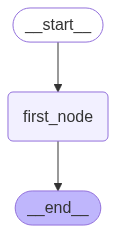

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [12]:
def chat(user_input:str, history):
    message = {"role":"user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content

In [13]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there', additional_kwargs={}, response_metadata={}, id='e8a14db6-11cf-4d64-8f4b-2cfc6014b324'), AIMessage(content='Cabbages are smelly', additional_kwargs={}, response_metadata={}, id='ca6bc911-5f92-4565-bbff-112ec621ce28')]}
{'messages': [HumanMessage(content='Test the fucking node inside the graph', additional_kwargs={}, response_metadata={}, id='731b2ee6-8198-459a-a636-80c64800a54a'), AIMessage(content='Unicorns are squishy', additional_kwargs={}, response_metadata={}, id='bb395ca9-83c2-4e7b-9e48-f40fceeb5fa4')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='2b7d3540-08cc-4859-8632-6c730842add8'), AIMessage(content='Cabbages are moody', additional_kwargs={}, response_metadata={}, id='d5932ddb-cef4-4ef4-bf81-3ccd788a77c0')]}


### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [45]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [46]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [47]:
# Step 3: Create a Node
llm = ChatOpenAI(model="mistralai/mixtral-8x7b-instruct")

In [48]:
def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

In [49]:
graph_builder.add_node("chatbot", chatbot_node)

In [50]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [51]:
# Step 5: Compile the Graph
graph = graph_builder.compile()

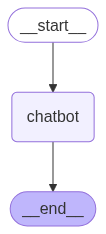

In [52]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Using gradio, run this guy, so we will have our first message and the output will the resulting from the graph

### That's it! And, let's do this:

In [53]:
def chat(user_input: str, history):
    messages = [{"role": "user", "content": user_input}]
    initial_state = State(messages=messages)
    # We give the graph a state, not a fucking message, a fucking state
    result = graph.invoke(initial_state)
    print(result)
    # last fucking message from the ai 
    return result['messages'][-1].content

In [54]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Are you there?', additional_kwargs={}, response_metadata={}, id='469b972f-92c3-471c-b856-5e53d7cb9d69'), AIMessage(content=' Yes, I am here. How can I help you today?\n\n(Note: I am an AI language model and is programmed to respond to various prompts and assist with a wide range of tasks, so feel free to ask me any question or give me any task you have in mind.)', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 12, 'total_tokens': 73, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'mistralai/mixtral-8x7b-instruct', 'system_fingerprint': None, 'id': 'gen-1749461573-XdSWMYNiuZldFVwf7Q1X', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--c17c7a9d-93f4-4c6e-98ad-fcf34c8f22c9-0', usage_metadata={'input_tokens': 12, 'output_tokens': 61, 'total_tokens': 73, 'input_token_details': {}, 'output_token_details': {}})]}
{'messages': [Human